In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import gaussian_kde
import seaborn as sns
import SimpleITK as sitk
import glob

In [2]:
import warnings
warnings.filterwarnings("ignore")

*this part was edited on Dec 23, 2020 (to obtain final diagrams)

**Voxel-specific slope** 

1) Define all the normalized b1 ranges (differ between nrm and cry)

In [2]:
b1_norm = np.array([820, 865, 910, 955, 1000, 1045])/1045
b1_norm_cry_6scan = b1_norm.reshape(-1,1)-1
b1_norm_cry_6scan

array([[-0.215311 ],
       [-0.1722488],
       [-0.1291866],
       [-0.0861244],
       [-0.0430622],
       [ 0.       ]])

In [3]:
b1_norm = np.array([785, 850, 915, 980, 1045])/1045
b1_norm_cry_5scan = b1_norm.reshape(-1,1)-1
b1_norm_cry_5scan

array([[-0.24880383],
       [-0.18660287],
       [-0.12440191],
       [-0.06220096],
       [ 0.        ]])

In [4]:
b1_norm = np.array([412, 432, 452, 472, 492, 512])/512
b1_norm_nrm_6scan = b1_norm.reshape(-1,1)-1
b1_norm_nrm_6scan

array([[-0.1953125],
       [-0.15625  ],
       [-0.1171875],
       [-0.078125 ],
       [-0.0390625],
       [ 0.       ]])

In [5]:
b1_norm = np.array([432, 452, 472, 492, 512])/512
b1_norm_nrm_5scan = b1_norm.reshape(-1,1)-1
b1_norm_nrm_5scan

array([[-0.15625  ],
       [-0.1171875],
       [-0.078125 ],
       [-0.0390625],
       [ 0.       ]])

In [18]:
#takes as input raw minc filenames, they should be ordered from lowest to greatest flip angle
def voxel_wise_lr_cry_6scan(mnc1, mnc2, mnc3, mnc4, mnc5, mnc6):
    im1 = sitk.ReadImage(mnc1)
    im2 = sitk.ReadImage(mnc2)
    im3 = sitk.ReadImage(mnc3)
    im4 = sitk.ReadImage(mnc4)
    im5 = sitk.ReadImage(mnc5)
    im6 = sitk.ReadImage(mnc6)
    #convert each image to a matrix, and flatten the matrix into a 1d array
    #at the same time, divide the result by the values at FA=1045 to normalize (this may yield some NaN division by 0)
    v6 = np.matrix.flatten(sitk.GetArrayFromImage(im6))
    v1 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im1)), v6)
    v2 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im2)), v6)
    v3 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im3)), v6)
    v4 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im4)),v6)
    v5 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im5)), v6)
    v6 = np.divide(v6, v6)
    #concatenate the vectors along a second dimension
    concat = np.stack((v1, v2, v3, v4, v5, v6), axis=-1)
    concat_centered = concat-1
    #create an empty array to hold the slopes
    voxel_num = v1.size
    slopes = np.zeros((voxel_num, 1))
    #perform the linear regression by looping over all voxels
    #skip any voxels with NaN values due to the normalization (these values remain 0)
    #for each voxel, add the slope from the linear regression to the slopes array
    for i in range(0, voxel_num):
        if np.isnan(concat[i,:]).any() == False:
            regr_obj = linear_model.LinearRegression(fit_intercept = False)
            regr_fit = regr_obj.fit(b1_norm_cry_6scan,concat_centered[i,:])
            slopes[i] = regr_fit.coef_
        else:
            continue
    slopes_matrix = np.reshape(slopes, (45,90,80))
    return slopes_matrix

In [19]:
#takes as input raw minc filenames, they should be ordered from lowest to greatest flip angle
def voxel_wise_lr_cry_5scan(mnc1, mnc2, mnc3, mnc4, mnc5):
    im1 = sitk.ReadImage(mnc1)
    im2 = sitk.ReadImage(mnc2)
    im3 = sitk.ReadImage(mnc3)
    im4 = sitk.ReadImage(mnc4)
    im5 = sitk.ReadImage(mnc5)
    #convert each image to a matrix, and flatten the matrix into a 1d array
    #at the same time, divide the result by the values at FA=1045 to normalize (this may yield some NaN division by 0)
    v5 = np.matrix.flatten(sitk.GetArrayFromImage(im5))
    v1 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im1)), v5)
    v2 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im2)), v5)
    v3 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im3)), v5)
    v4 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im4)),v5)
    v5 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im5)), v5)
    #concatenate the vectors along a second dimension
    concat = np.stack((v1, v2, v3, v4, v5), axis=-1)
    concat_centered = concat-1
    #create an empty array to hold the slopes
    voxel_num = v1.size
    slopes = np.zeros((voxel_num, 1))
    #perform the linear regression by looping over all voxels
    #skip any voxels with NaN values due to the normalization (these values remain 0)
    #for each voxel, add the slope from the linear regression to the slopes array
    for i in range(0, voxel_num):
        if np.isnan(concat[i,:]).any() == False:
            regr_obj = linear_model.LinearRegression(fit_intercept = False)
            regr_fit = regr_obj.fit(b1_norm_cry_5scan,concat_centered[i,:])
            slopes[i] = regr_fit.coef_
        else:
            continue
    slopes_matrix = np.reshape(slopes, (45,90,80))
    return slopes_matrix

In [20]:
#takes as input raw minc filenames, they should be ordered from lowest to greatest flip angle
def voxel_wise_lr_nrm_6scan(mnc1, mnc2, mnc3, mnc4, mnc5, mnc6):
    im1 = sitk.ReadImage(mnc1)
    im2 = sitk.ReadImage(mnc2)
    im3 = sitk.ReadImage(mnc3)
    im4 = sitk.ReadImage(mnc4)
    im5 = sitk.ReadImage(mnc5)
    im6 = sitk.ReadImage(mnc6)
    #convert each image to a matrix, and flatten the matrix into a 1d array
    #at the same time, divide the result by the values at FA=512 to normalize (this may yield some NaN division by 0)
    v6 = np.matrix.flatten(sitk.GetArrayFromImage(im6))
    v1 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im1)), v6)
    v2 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im2)), v6)
    v3 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im3)), v6)
    v4 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im4)),v6)
    v5 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im5)), v6)
    v6 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im6)), v6)
    #concatenate the vectors along a second dimension
    concat = np.stack((v1, v2, v3, v4, v5, v6), axis=-1)
    concat_centered = concat-1
    #create an empty array to hold the slopes
    voxel_num = v1.size
    slopes = np.zeros((voxel_num, 1))
    #perform the linear regression by looping over all voxels
    #skip any voxels with NaN values due to the normalization (these values remain 0)
    #for each voxel, add the slope from the linear regression to the slopes array
    for i in range(0, voxel_num):
        if np.isnan(concat[i,:]).any() == False:
            regr_obj = linear_model.LinearRegression(fit_intercept = False)
            regr_fit = regr_obj.fit(b1_norm_nrm_6scan,concat_centered[i,:])
            slopes[i] = regr_fit.coef_
        else:
            continue
    slopes_matrix = np.reshape(slopes, (45,90,80))
    return slopes_matrix

In [21]:
#takes as input raw minc filenames, they should be ordered from lowest to greatest flip angle
def voxel_wise_lr_nrm_5scan(mnc1, mnc2, mnc3, mnc4, mnc5):
    im1 = sitk.ReadImage(mnc1)
    im2 = sitk.ReadImage(mnc2)
    im3 = sitk.ReadImage(mnc3)
    im4 = sitk.ReadImage(mnc4)
    im5 = sitk.ReadImage(mnc5)
    #convert each image to a matrix, and flatten the matrix into a 1d array
    #at the same time, divide the result by the values at FA=1045 to normalize (this may yield some NaN division by 0)
    v5 = np.matrix.flatten(sitk.GetArrayFromImage(im5))
    v1 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im1)), v5)
    v2 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im2)), v5)
    v3 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im3)), v5)
    v4 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im4)),v5)
    v5 = np.divide(np.matrix.flatten(sitk.GetArrayFromImage(im5)), v5)
    #concatenate the vectors along a second dimension
    concat = np.stack((v1, v2, v3, v4, v5), axis=-1)
    concat_centered = concat-1
    #create an empty array to hold the slopes
    voxel_num = v1.size
    slopes = np.zeros((voxel_num, 1))
    #perform the linear regression by looping over all voxels
    #skip any voxels with NaN values due to the normalization (these values remain 0)
    #for each voxel, add the slope from the linear regression to the slopes array
    for i in range(0, voxel_num):
        if np.isnan(concat[i,:]).any() == False:
            regr_obj = linear_model.LinearRegression(fit_intercept = False)
            regr_fit = regr_obj.fit(b1_norm_nrm_5scan,concat_centered[i,:])
            slopes[i] = regr_fit.coef_
        else:
            continue
    slopes_matrix = np.reshape(slopes, (45,90,80))
    return slopes_matrix

2) Load the files (denoised + eroded) for all cryo and nrm subjects. These ones are not masked according to the B1 map.

In [67]:
#run for ccx_003, 004 and 005
ccx_003_files_d_e = sorted(glob.glob('./calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded/*ccx_003*'))
ccx_005_files_d_e = sorted(glob.glob('./calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded/*ccx_005*'))
ccx_009_files_d_e = sorted(glob.glob('./calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded/*ccx_009*'))
ccx_010_files_d_e = sorted(glob.glob('./calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded/*ccx_010*'))
cry_122_files_d_e = sorted(glob.glob('./calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded/*cry_122*'))

In [23]:
#run for mil_001, 004 and 005
mil_001_files_d_e = sorted(glob.glob('./calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded/*mil_001*'))
nrm_122_files_d_e = sorted(glob.glob('./calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded/*nrm_122*'))
nrm_133_files_d_e = sorted(glob.glob('./calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded/*nrm_133*'))
nrm_144_files_d_e = sorted(glob.glob('./calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded/*nrm_144*'))
nrm_155_files_d_e = sorted(glob.glob('./calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded/*nrm_155*'))

In [69]:
ccx_010_files_d_e

['./calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded\\ccx_010_mt_1000_mtr_map_imagemath_denoised_eroded.mnc',
 './calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded\\ccx_010_mt_1045_mtr_map_imagemath_denoised_eroded.mnc',
 './calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded\\ccx_010_mt_820_mtr_map_imagemath_denoised_eroded.mnc',
 './calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded\\ccx_010_mt_865_mtr_map_imagemath_denoised_eroded.mnc',
 './calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded\\ccx_010_mt_910_mtr_map_imagemath_denoised_eroded.mnc',
 './calibration_final_oct2020/minc_files/mtr_maps_denoised_eroded\\ccx_010_mt_955_mtr_map_imagemath_denoised_eroded.mnc']

3) Run the voxel wise linear regression on the minc files for each subject, whole brain.

In [25]:
slopes_ccx_003_d_e = voxel_wise_lr_cry_6scan(ccx_003_files_d_e[2], ccx_003_files_d_e[3], ccx_003_files_d_e[4], ccx_003_files_d_e[5], ccx_003_files_d_e[0], ccx_003_files_d_e[1])
slopes_ccx_005_d_e = voxel_wise_lr_cry_6scan(ccx_005_files_d_e[2], ccx_005_files_d_e[3], ccx_005_files_d_e[4], ccx_005_files_d_e[5], ccx_005_files_d_e[0], ccx_005_files_d_e[1])
slopes_ccx_009_d_e = voxel_wise_lr_cry_6scan(ccx_009_files_d_e[2], ccx_009_files_d_e[3], ccx_009_files_d_e[4], ccx_009_files_d_e[5], ccx_009_files_d_e[0], ccx_009_files_d_e[1])
slopes_ccx_010_d_e = voxel_wise_lr_cry_6scan(ccx_010_files_d_e[2], ccx_010_files_d_e[3], ccx_010_files_d_e[4], ccx_010_files_d_e[5], ccx_010_files_d_e[0], ccx_010_files_d_e[1])
slopes_cry_122_d_e = voxel_wise_lr_cry_5scan(cry_122_files_d_e[1], cry_122_files_d_e[2], cry_122_files_d_e[3], cry_122_files_d_e[4], cry_122_files_d_e[0])

In [29]:
slopes_mil_001_d_e = voxel_wise_lr_nrm_6scan(*mil_001_files_d_e)
slopes_nrm_122_d_e = voxel_wise_lr_nrm_6scan(*nrm_122_files_d_e)
slopes_nrm_133_d_e = voxel_wise_lr_nrm_6scan(*nrm_133_files_d_e)
slopes_nrm_144_d_e = voxel_wise_lr_nrm_5scan(*nrm_144_files_d_e)
slopes_nrm_155_d_e = voxel_wise_lr_nrm_5scan(*nrm_155_files_d_e)

<function matplotlib.pyplot.show(*args, **kw)>

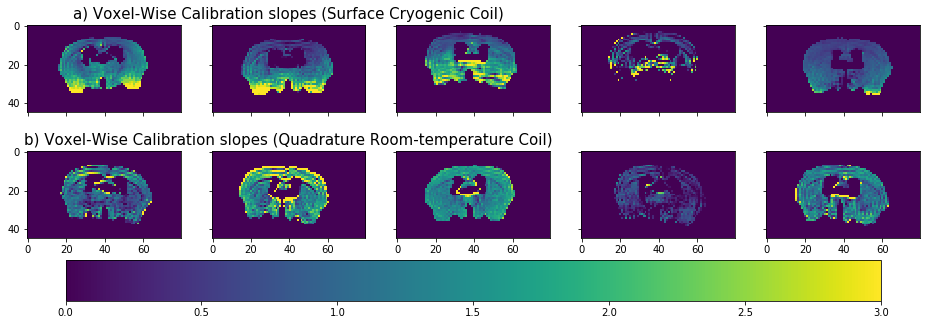

In [74]:
#plot the ccx results all in the same plot
#viewing other slices (eg 40 gives weird results, so just choose average based on the coronal slice)
s = 47 #choose the coronal slice to view
fig, axs = plt.subplots(2, 5, figsize=(16,5), sharey = True, sharex = True)
pic1_d_e = axs[0,0].imshow(slopes_ccx_003_d_e[::-1,s,:], vmin=0, vmax=3)
pic2_d_e = axs[0,1].imshow(slopes_ccx_005_d_e[::-1,s,:], vmin=0, vmax=3)
pic3_d_e = axs[0,2].imshow(slopes_ccx_009_d_e[::-1,s,:], vmin=0, vmax=3)
pic4_d_e = axs[0,3].imshow(slopes_ccx_010_d_e[::-1,s,:], vmin=0, vmax=3)
pic5_d_e = axs[0,4].imshow(slopes_cry_122_d_e[::-1,s,:], vmin=0, vmax=3)
#I'm not even showing ccx_004 here.

pic6_d_e = axs[1,0].imshow(slopes_mil_001_d_e[::-1,s,:], vmin=0, vmax=3)
pic7_d_e = axs[1,1].imshow(slopes_nrm_122_d_e[::-1,s,:], vmin=0, vmax=3)
pic8_d_e = axs[1,2].imshow(slopes_nrm_133_d_e[::-1,s,:], vmin=0, vmax=3)
pic9_d_e = axs[1,3].imshow(slopes_nrm_144_d_e[::-1,s,:], vmin=0, vmax=3)
pic10_d_e = axs[1,4].imshow(slopes_nrm_155_d_e[::-1,s,:], vmin=0, vmax=3)

fig.colorbar(pic1_d_e, ax=axs, orientation='horizontal')
plt.subplots_adjust(bottom = 0.3, top = 1, hspace=0.001)
axs[0,1].set_title('a) Voxel-Wise Calibration slopes (Surface Cryogenic Coil)', fontsize = 15)
axs[1,1].set_title('b) Voxel-Wise Calibration slopes (Quadrature Room-temperature Coil)', fontsize = 15)
plt.show

**Average slope for all subjects-NRM coil (inside b1 mask)**

*this part was edited on Jan 11, 2021 (to obtain final slope diagrams)*

In [6]:
#this data was created from the whole brain mtr maps, except without csf. Dont yet have tissue specific dataframes
df_nrm_d_e = pd.read_csv("./files_for_code/calibration_final_oct2020/nrm_calib_files/calib_means_mtr_maps_denoised_eroded_6scan.csv")

In [7]:
#extract normalized b1 values (just reverse order of the arrays defined earlier)
b1_nrm6_centered_rev = np.flip(b1_norm_nrm_6scan)
b1_nrm5_centered_rev = np.flip(b1_norm_nrm_5scan)

In [8]:
#normalize means for each subject (creates new column to hold normalized means)
#repeat for each dataframe
df = df_nrm_d_e
max_values = [df.iloc[0, 2]]*6 + [df.iloc[6, 2]]*6 + [df.iloc[12, 2]]*6+ [df.iloc[18, 2]]*5 + [df.iloc[23,2]]*5
df["Normalized_means"] = df[' mean']/max_values
df_nrm_d_e=df

**Do fitting for each individual mouse (nrm only) - without intercept fitting**

In [9]:
df_nrm_d_e

,subject,FA,mean,stddev,Normalized_means
0,nrm_133,512,0.408632,0.045506,1.000000
1,nrm_133,492,0.372411,0.048189,0.911361
2,nrm_133,472,0.354125,0.050710,0.866610
3,nrm_133,452,0.347306,0.051834,0.849924
4,nrm_133,432,0.313089,0.053209,0.766188
5,nrm_133,412,0.288953,0.055229,0.707122
6,nrm_122,512,0.291408,0.094275,1.000000
7,nrm_122,492,0.270728,0.059605,0.929035
8,nrm_122,472,0.260699,0.061750,0.894617
9,nrm_122,452,0.239945,0.064823,0.823398


In [10]:
regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_155_d_e = regr_obj.fit(b1_nrm5_centered_rev,df_nrm_d_e.iloc[23:28, 4:5]-1)

regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_144_d_e = regr_obj.fit(b1_nrm5_centered_rev,df_nrm_d_e.iloc[18:23, 4:5]-1)

regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_133_d_e = regr_obj.fit(b1_nrm6_centered_rev,df_nrm_d_e.iloc[0:6, 4:5]-1)

regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_122_d_e = regr_obj.fit(b1_nrm6_centered_rev,df_nrm_d_e.iloc[6:12, 4:5]-1)

regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_mil_001_d_e = regr_obj.fit(b1_nrm6_centered_rev,df_nrm_d_e.iloc[12:18, 4:5]-1)

In [11]:
print('slope:', regr_144_d_e.coef_, 'and intercept:', regr_144_d_e.intercept_)
print('slope:', regr_122_d_e.coef_, 'and intercept:', regr_122_d_e.intercept_)
print('slope:', regr_133_d_e.coef_, 'and intercept:', regr_133_d_e.intercept_)
print('slope:', regr_155_d_e.coef_, 'and intercept:', regr_155_d_e.intercept_)
print('slope:', regr_mil_001_d_e.coef_, 'and intercept:', regr_mil_001_d_e.intercept_)

slope: [[0.41783182]] and intercept: 0.0
slope: [[1.20830697]] and intercept: 0.0
slope: [[1.49191393]] and intercept: 0.0
slope: [[1.27758697]] and intercept: 0.0
slope: [[1.05598967]] and intercept: 0.0


In [12]:
avg_nrm_slope = (1.20830697 + 1.49191393 + 1.27758695 + 1.05598967)/4
avg_nrm_slope

1.2584493799999998

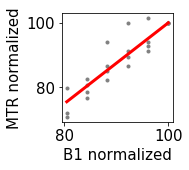

In [15]:
#plot the slope and all the points(nrm)
plt.figure(figsize = (2,2))
size=6
col = 'grey'
plt.plot(100*(b1_nrm5_centered_rev+1), 100*df_nrm_d_e.iloc[23:28, 4:5], '.', markersize = size, color=col)
plt.plot(100*(b1_nrm6_centered_rev+1), 100*df_nrm_d_e.iloc[0:6, 4:5], '.', markersize = size, color=col)
plt.plot(100*(b1_nrm6_centered_rev+1), 100*df_nrm_d_e.iloc[6:12, 4:5], '.', markersize = size, color=col)
plt.plot(100*(b1_nrm6_centered_rev+1), 100*df_nrm_d_e.iloc[12:18, 4:5], '.', markersize = size, color=col)

plt.plot(100*(b1_nrm6_centered_rev+1), 100*((avg_nrm_slope*b1_nrm6_centered_rev)+1), '-', linewidth = 3, color='red')

plt.xlabel("B1 normalized", fontsize = 15)
plt.ylabel("MTR normalized", fontsize = 15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.show()

**Average slope for all subjects-CRYO (inside b1 mask)**

In [16]:
#this data was created from the whole brain mtr maps, except without csf. Dont yet have tissue specific dataframes
df_cry_d_e_mask08 = pd.read_csv("./files_for_code/calibration_final_oct2020/calib_means_mtr_maps_denoised_eroded_b1_mask_08.csv")

In [17]:
#extract normalized b1 values (just reverse order of the arrays defined earlier)
b1_norm_centered_rev = np.flip(b1_norm_cry_6scan)
b1_norm_centered_5scan_rev = np.flip(b1_norm_cry_5scan)

In [18]:
#normalize means for each subject (creates new column to hold normalized means)
df = df_cry_d_e_mask08
max_values = [df.iloc[0, 2]]*5 + [df.iloc[5, 2]]*6 + [df.iloc[11, 2]]*6 + [df.iloc[17,2]]*6
df["Normalized_means"] = df[' mean']/max_values
df_cry_d_e_mask08=df

**Do fitting for each individual mouse (cry only) - without intercept fitting**

In [19]:
regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_003_d_e_mask08 = regr_obj.fit(b1_norm_centered_rev,df_cry_d_e_mask08.iloc[11:17, 4:5]-1)

regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_122_d_e_mask08 = regr_obj.fit(b1_norm_centered_5scan_rev,df_cry_d_e_mask08.iloc[0:5, 4:5]-1)

regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_005_d_e_mask08 = regr_obj.fit(b1_norm_centered_rev,df_cry_d_e_mask08.iloc[5:11, 4:5]-1)

regr_obj = linear_model.LinearRegression(fit_intercept = False)
regr_009_d_e_mask08 = regr_obj.fit(b1_norm_centered_rev,df_cry_d_e_mask08.iloc[17:23, 4:5]-1)

In [20]:
print('slope:', regr_003_d_e_mask08.coef_, 'and intercept:', regr_003_d_e_mask08.intercept_)
print('slope:', regr_122_d_e_mask08.coef_, 'and intercept:', regr_122_d_e_mask08.intercept_)
print('slope:', regr_005_d_e_mask08.coef_, 'and intercept:', regr_005_d_e_mask08.intercept_)
print('slope:', regr_009_d_e_mask08.coef_, 'and intercept:', regr_009_d_e_mask08.intercept_)

slope: [[1.27543431]] and intercept: 0.0
slope: [[0.83057899]] and intercept: 0.0
slope: [[1.09733052]] and intercept: 0.0
slope: [[1.18006497]] and intercept: 0.0


In [21]:
avg_08_cry_slope = (1.27543431 + 1.09733052 + 1.18006497)/3
avg_08_cry_slope

1.1842766000000002

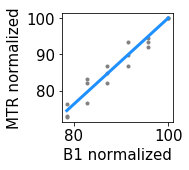

In [23]:
#plot the slope and all the points(nrm)
plt.figure(figsize = (2,2))
size=6
col = 'grey'
plt.plot(100*(b1_norm_centered_rev+1), 100*df_cry_d_e_mask08.iloc[11:17, 4:5], '.', markersize = size, color=col)
plt.plot(100*(b1_norm_centered_rev+1), 100*df_cry_d_e_mask08.iloc[5:11, 4:5], '.', markersize = size, color=col)
plt.plot(100*(b1_norm_centered_rev+1), 100*df_cry_d_e_mask08.iloc[17:23, 4:5], '.', markersize = size, color=col)

plt.plot(100*(b1_norm_centered_rev+1), 100*((avg_08_cry_slope*b1_norm_centered_rev)+1), '-', linewidth = 3, color='dodgerblue')

plt.xlabel("B1 normalized", fontsize = 15)
plt.ylabel("MTR normalized", fontsize = 15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.show()